# 最適発射角度の探索

発射ロッド角度を最適化して、着地点が発射地点にできるだけ近くなる角度を求める。

In [1]:
import math

import jpype
import numpy as np
from scipy.optimize import fmin
from matplotlib import pyplot as plt

import orhelper
from orhelper import FlightDataType

# Java 17+ 用: --add-opens オプションを追加
_original_startJVM = jpype.startJVM

def _patched_startJVM(*args, **kwargs):
    add_opens = [
        "--add-opens=java.base/java.lang=ALL-UNNAMED",
        "--add-opens=java.base/java.lang.reflect=ALL-UNNAMED",
        "--add-opens=java.base/java.util=ALL-UNNAMED",
    ]
    _original_startJVM(*args, *add_opens, **kwargs)

jpype.startJVM = _patched_startJVM

In [2]:
instance = orhelper.OpenRocketInstance()
instance.__enter__()
orh = orhelper.Helper(instance)

doc = orh.load_doc('simple.ork')
sim = doc.getSimulation(0)

22:35:43.683 [main] INFO  n.s.o.s.providers.TranslatorProvider - Using default locale ja_JP
22:35:43.698 [main] INFO  n.s.o.s.providers.TranslatorProvider - Set up translation for locale ja_JP, debug.currentFile=messages_ja.properties
22:35:43.702 [DatabaseLoadingThread] INFO  n.s.o.d.ComponentPresetDatabaseLoader - Loading component presets from datafiles/presets
22:35:43.704 [DatabaseLoadingThread] DEBUG net.sf.openrocket.util.JarUtil - Found jar file using codeSource
22:35:43.704 [DatabaseLoadingThread] INFO  n.s.o.database.MotorDatabaseLoader - Starting reading serialized motor database
22:35:43.704 [DatabaseLoadingThread] DEBUG net.sf.openrocket.util.JarUtil - Found jar file using codeSource
22:35:43.707 [DatabaseLoadingThread] DEBUG n.s.o.database.MotorDatabaseLoader - Reading motors from file datafiles/thrustcurves/thrustcurves.ser
22:35:43.840 [DatabaseLoadingThread] INFO  n.s.o.database.MotorDatabaseLoader - Ending reading serialized motor database, motorCount=1721
22:35:43.84

In [3]:
def simulate_at_angle(ang, sim):
    ang = np.asarray(ang).item()
    sim.getOptions().setLaunchRodAngle(math.radians(ang))
    orh.run_simulation(sim)
    return orh.get_timeseries(sim, [FlightDataType.TYPE_ALTITUDE, FlightDataType.TYPE_POSITION_X])


def to_min(ang, sim):
    data = simulate_at_angle(ang, sim)
    half_len = len(data[FlightDataType.TYPE_ALTITUDE]) // 2
    min_upwind_index = np.abs(data[FlightDataType.TYPE_ALTITUDE][half_len:]).argmin()
    min_upwind_position = data[FlightDataType.TYPE_POSITION_X][half_len:][min_upwind_index]
    return np.abs(min_upwind_position)

In [4]:
# 最適な発射角度を探索
optimal = fmin(to_min, (40,), args=(sim,))

angles = np.linspace(0, 30.0, num=10)
angles = np.append(angles, optimal)
angles.sort()

# 各角度でシミュレーション実行
data_runs = dict()
for ang in angles:
    data_runs[ang] = simulate_at_angle(ang, sim)

/tmp/ipykernel_3943040/1502206749.py:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  optimal = fmin(to_min, (40,), args=(sim,))


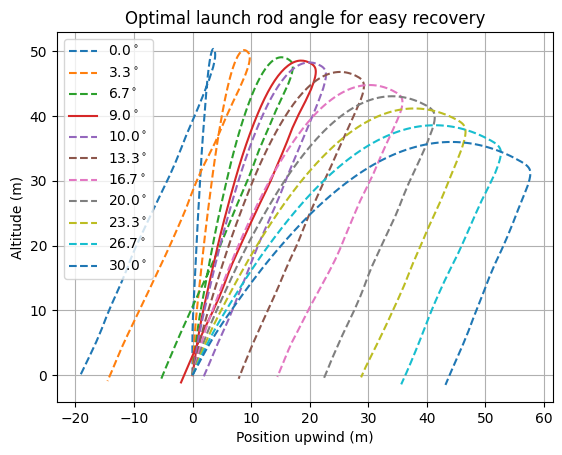

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for ang, data in data_runs.items():
    ax1.plot(data[FlightDataType.TYPE_POSITION_X], data[FlightDataType.TYPE_ALTITUDE],
             label=r'%3.1f$^\circ$' % ang,
             linestyle='-' if ang == optimal else '--')

ax1.legend()
ax1.set_xlabel('Position upwind (m)')
ax1.set_ylabel('Altitude (m)')
ax1.set_title('Optimal launch rod angle for easy recovery')
ax1.grid(True)
plt.show()

In [6]:
# JVMをシャットダウン (カーネル再起動前に実行)
instance.__exit__(None, None, None)